In [197]:
import numpy as np
import pandas as pd
import pickle
import pydotplus
import seaborn as sns
import sys
import time
import warnings
import zipfile

from collections import (Counter,)
from imblearn.under_sampling \
    import (RandomUnderSampler,
            ClusterCentroids,
            TomekLinks,)
from imblearn.over_sampling \
    import (RandomOverSampler,
            SMOTE,)
from io import (StringIO,)
from IPython.display import (Image,)
from matplotlib import (pyplot as plt,)
from mlxtend.classifier import (StackingClassifier,)
from scipy import (stats,)
from scipy.cluster import (hierarchy as sch,)
from sklearn.cluster \
    import (KMeans,
            AgglomerativeClustering,)
from sklearn.datasets import (make_moons,)
from sklearn.decomposition import (PCA,) 
from sklearn.ensemble \
    import (AdaBoostClassifier,
            BaggingClassifier,
            ExtraTreesClassifier,
            GradientBoostingClassifier,
            RandomForestClassifier,
            VotingClassifier,)
from sklearn.feature_selection \
    import (chi2,
            f_regression,
            f_classif,
            RFE,
            SelectFromModel,
            SelectKBest,
            SelectPercentile,)
from sklearn.linear_model \
    import (Lasso,
            LogisticRegression,
            LinearRegression,
            Ridge,)
from sklearn.metrics \
    import (accuracy_score,
            auc,
            classification_report,
            confusion_matrix,
            f1_score,
            precision_score,
            precision_recall_fscore_support as error_metric,
            r2_score,
            recall_score,
            roc_auc_score,
            roc_curve,)
from sklearn.model_selection \
    import (GridSearchCV,
            RandomizedSearchCV,
            train_test_split,)
from sklearn.multiclass import (OneVsRestClassifier,)
from sklearn.pipeline import (make_pipeline,)
from sklearn.preprocessing \
    import (LabelEncoder,
            MinMaxScaler,
            StandardScaler,)
from sklearn.svm \
    import (LinearSVC,
            LinearSVC,
            SVC,)
from sklearn.tree \
    import (DecisionTreeClassifier,
            DecisionTreeRegressor,)
from xgboost import (XGBClassifier,)

warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)

In [207]:
def plot_auc(y_test, y_pred):
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def get_scores(model, X_test, y_test,):
    y_pred = model.predict(X_test,)
    print("Accuracy: {0}".format(accuracy_score(y_test, y_pred,)))
    print("\n")
    print("Recall: {0}".format(recall_score(y_test, y_pred,)))
    print("Precision: {0}".format(precision_score(y_test, y_pred,)))
    print("F1 Score: {0}".format(f1_score(y_test, y_pred,)))
    print("\n")
    print("ROC AUC: {0}".format(roc_auc_score(y_test, y_pred,)))
    print("\n")
    print("Confusion Matrix: \n{0}".format(confusion_matrix(y_test, y_pred,)))
    print("\n")
    print("Classification Report: \n{0}".format(classification_report(y_test, y_pred,)))
    plot_auc(y_test, y_pred)

2. correlations between features
destination vs commisions <br>
dest vs gender <br>
dest vs age <br>
dest vs sales/net sales <br>
dest vs prod name <br>
relationship between dist channel and dest of travel <br>
preference for dest within a certain group of people? <br>
duration of travel vs destination <br>
avg dur of travel vs destination <br>
age outliers <br>
duration of trip (0) interpretation <br>

#### Reading data from csv files

In [5]:
path_train = "train.csv"
path_test = "test.csv"
path_submission_sample = "sample_submission.csv"


In [6]:
train = pd.read_csv(path_train)
print(train.head(1).T)

                                                    0
ID                                               3433
Agency                                            CWT
Agency Type                             Travel Agency
Distribution Channel                           Online
Product Name          Rental Vehicle Excess Insurance
Claim                                               0
Duration                                            7
Destination                                  MALAYSIA
Net Sales                                           0
Commision (in value)                            17.82
Gender                                            NaN
Age                                                31


In [7]:
test = pd.read_csv(path_test)
print(test.head(1).T)


                                                    0
ID                                              25902
Agency                                            CWT
Agency Type                             Travel Agency
Distribution Channel                           Online
Product Name          Rental Vehicle Excess Insurance
Duration                                           58
Destination                                   ICELAND
Net Sales                                        49.5
Commision (in value)                             29.7
Gender                                            NaN
Age                                                47


In [8]:
sample_submission = pd.read_csv(path_submission_sample)
print(sample_submission.head(4).T)

           0      1      2      3
ID     25902  19535  43717  48271
Claim      0      0      0      0


#### Checking for missing values

In [9]:
def check_null(df):
    to_return = df.isnull().sum().to_frame()
    to_return.columns = ['Number_Missing']
    to_return['% Missing'] = (to_return['Number_Missing']/len(df))*100
    to_return['Missing?'] = df.isnull().any()
    return to_return
    
# Checking for missing values
print(check_null(train))
print(check_null(test))


                      Number_Missing  % Missing  Missing?
ID                                 0   0.000000     False
Agency                             0   0.000000     False
Agency Type                        0   0.000000     False
Distribution Channel               0   0.000000     False
Product Name                       0   0.000000     False
Claim                              0   0.000000     False
Duration                           0   0.000000     False
Destination                        0   0.000000     False
Net Sales                          0   0.000000     False
Commision (in value)               0   0.000000     False
Gender                         35953  71.119419      True
Age                                0   0.000000     False
                      Number_Missing  % Missing  Missing?
ID                                 0   0.000000     False
Agency                             0   0.000000     False
Agency Type                        0   0.000000     False
Distribution C

#### High number of missing values found, dropping Gender

In [10]:
# Missing values are too high for gender in both training and testing sets

for df_ in (train, test):
    # Dropping Gender
    df_.drop('Gender', axis=1, inplace=True,)
    # Veriying missing
    print(check_null(df_))


                      Number_Missing  % Missing  Missing?
ID                                 0        0.0     False
Agency                             0        0.0     False
Agency Type                        0        0.0     False
Distribution Channel               0        0.0     False
Product Name                       0        0.0     False
Claim                              0        0.0     False
Duration                           0        0.0     False
Destination                        0        0.0     False
Net Sales                          0        0.0     False
Commision (in value)               0        0.0     False
Age                                0        0.0     False
                      Number_Missing  % Missing  Missing?
ID                                 0        0.0     False
Agency                             0        0.0     False
Agency Type                        0        0.0     False
Distribution Channel               0        0.0     False
Product Name  

#### Printing .info() to check for kinds of columns

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50553 entries, 0 to 50552
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    50553 non-null  int64  
 1   Agency                50553 non-null  object 
 2   Agency Type           50553 non-null  object 
 3   Distribution Channel  50553 non-null  object 
 4   Product Name          50553 non-null  object 
 5   Claim                 50553 non-null  int64  
 6   Duration              50553 non-null  int64  
 7   Destination           50553 non-null  object 
 8   Net Sales             50553 non-null  float64
 9   Commision (in value)  50553 non-null  float64
 10  Age                   50553 non-null  int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 4.2+ MB


#### Creating list to contain names of numerical and categorical columns
* ID isn't useful and claim is the target variable, so excluded

In [12]:
# Claim is the target variable so won't be changed as it's already in binary

cols_cat = [train.columns[i] for i in [1, 2, 3, 4, 7,] ]
cols_num = [train.columns[i] for i in [6, 8, 9, 10,] ]

#### Plotting the categorical columns


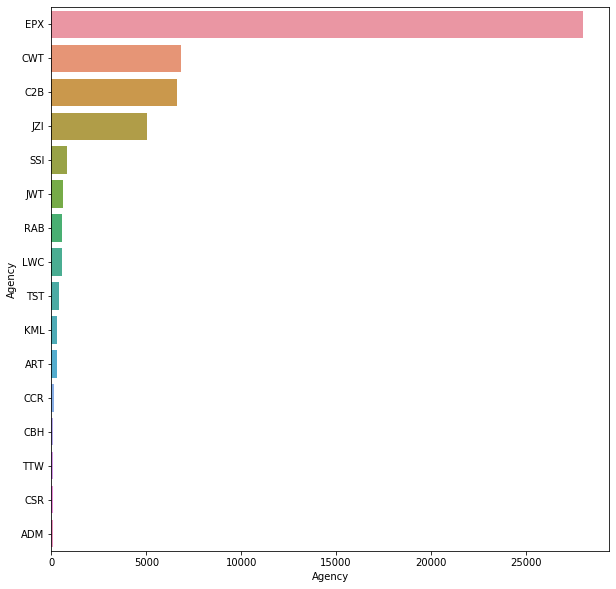

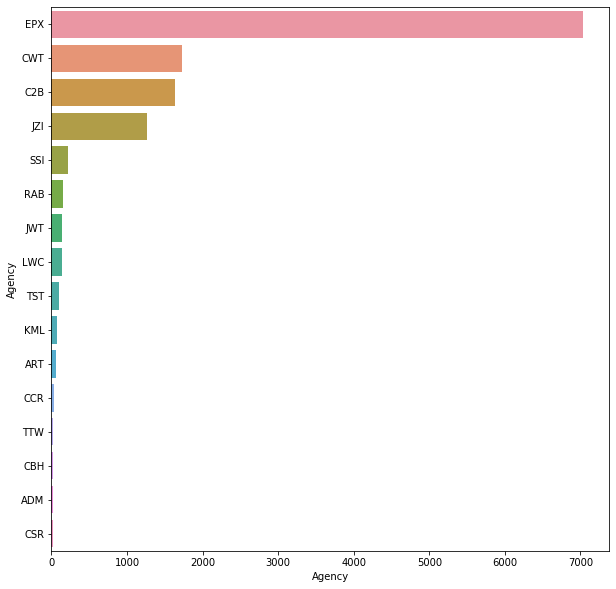

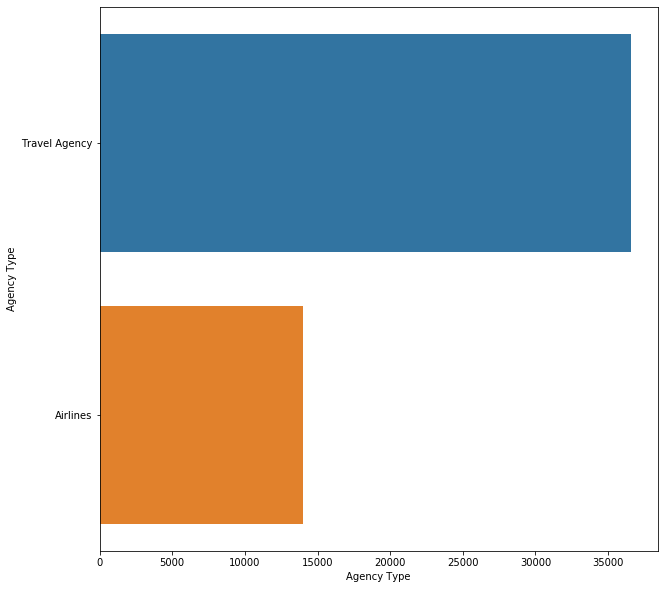

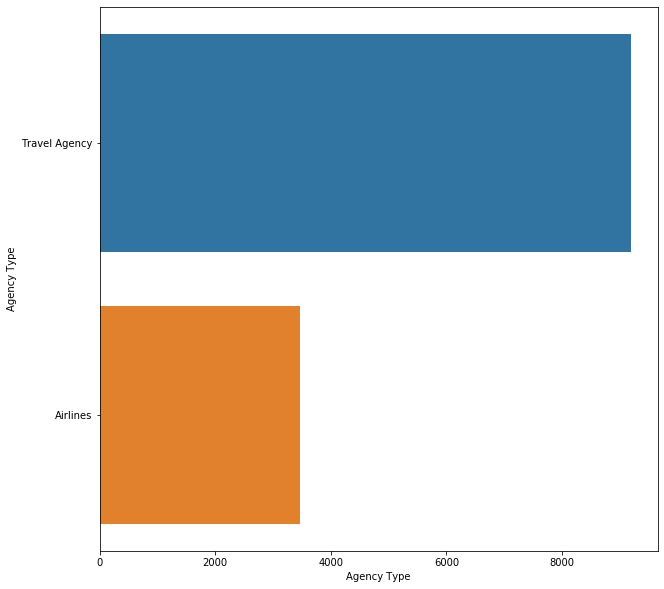

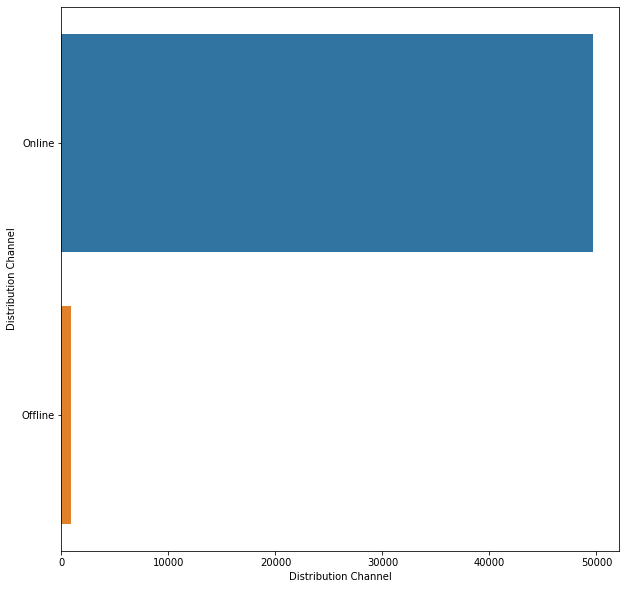

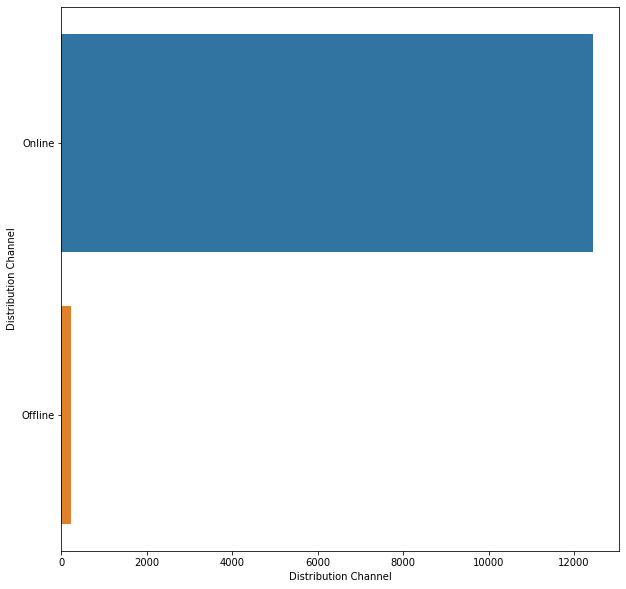

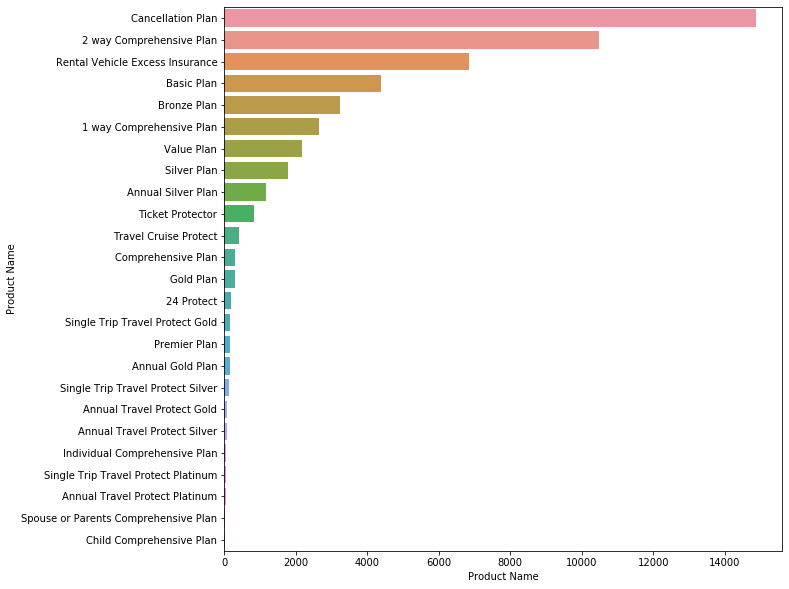

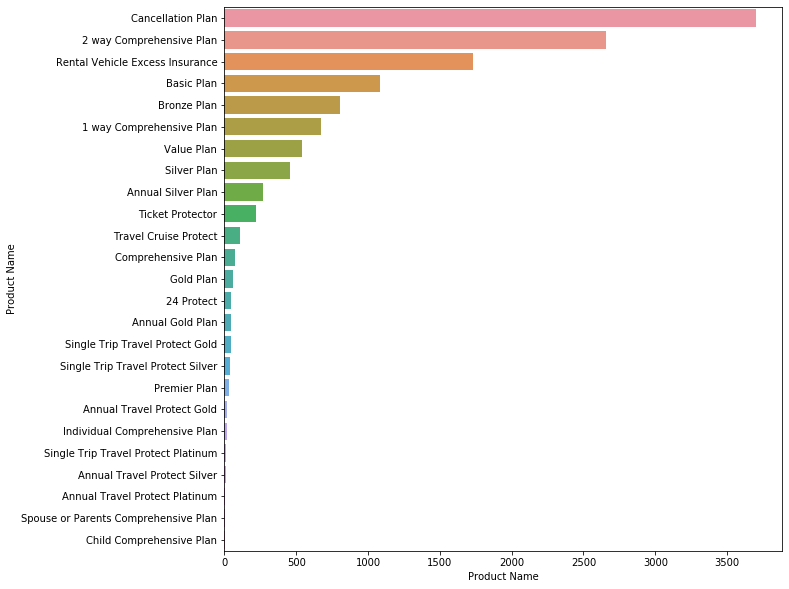

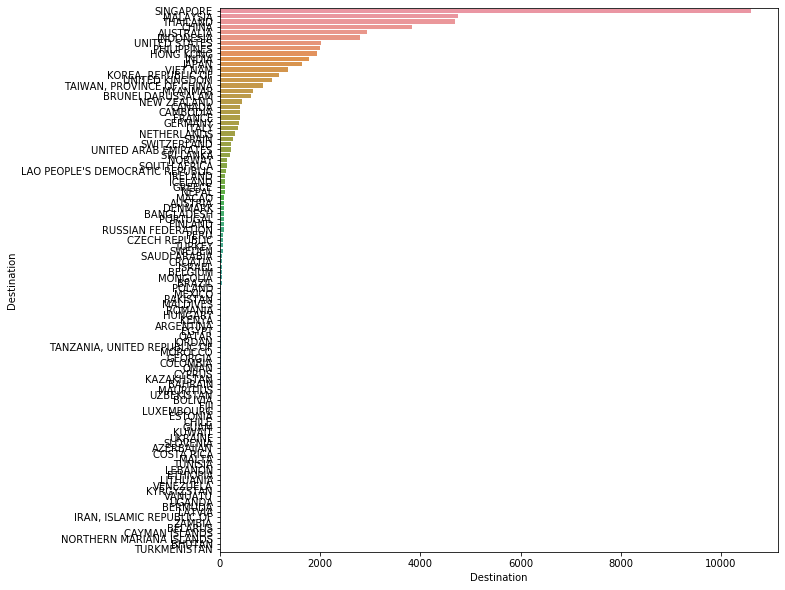

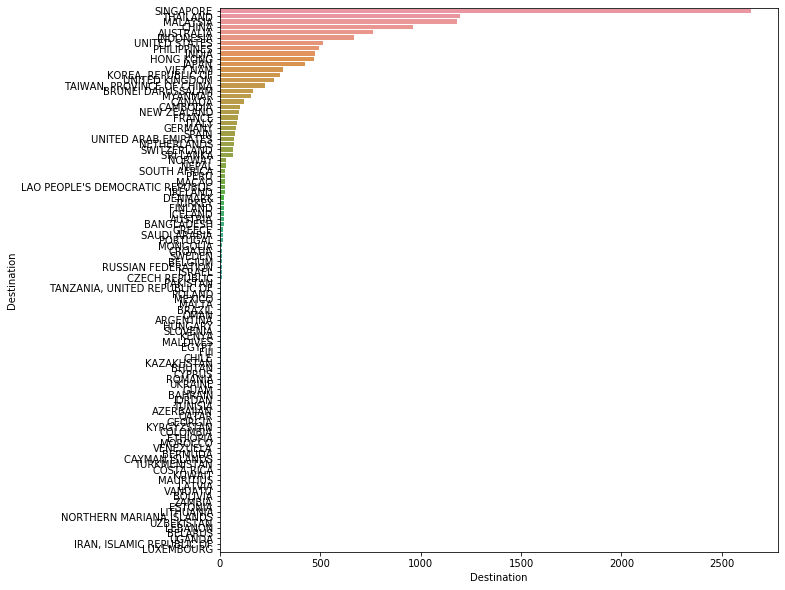

In [13]:
# pycharm slow

for col in cols_cat:
    for df_ in (train, test):
        plt.figure(figsize=(10, 10,),)
        fig = sns.countplot(y=df_[col], order=df_[col].value_counts().index,)
        fig.set_xlabel(col)
        plt.show()
        

* Exponential distribution found in
    * Agency
    * Product Name
    * Destination
* Bernoulli Distribution found in
    * Distribution Channel (imbalanced)
    * Agency Type (somewhat balanced) 

#### Checking what the categorical columns look like in the dataframes

In [14]:
def compare_train_test_cols(col_train, col_test,):
    df_ = ["", "",]
    cols = (col_train, col_test,)
    labels = ("Train", "Test")
    
    for i in range(0, 2):
        df_[i] = cols[i].value_counts().to_frame()
        df_[i].columns = [f'{labels[i]} Values']
        df_[i][f'{labels[i]} %'] = np.around(df_[i][f'{labels[i]} Values']/len(cols[i])*100, 
                                      decimals=2,)
        df_[i].reset_index(inplace=True)

    df_req = pd.merge(df_[0], df_[1], how='outer', on='index',)
    df_req.set_index('index', inplace=True,)
    df_req.fillna(0, inplace=True)
    return df_req

for col in cols_cat:
    print(f'\nColumn: {col}:\n')
    print(compare_train_test_cols(train[col], test[col]))
    print('='*80)




Column: Agency:

       Train Values  Train %  Test Values  Test %
index                                            
EPX           28002    55.39         7032   55.54
CWT            6840    13.53         1728   13.65
C2B            6631    13.12         1636   12.92
JZI            5059    10.01         1260    9.95
SSI             839     1.66          217    1.71
JWT             606     1.20          143    1.13
RAB             571     1.13          154    1.22
LWC             548     1.08          138    1.09
TST             421     0.83          106    0.84
KML             317     0.63           74    0.58
ART             272     0.54           59    0.47
CCR             158     0.31           36    0.28
CBH              81     0.16           20    0.16
TTW              77     0.15           21    0.17
CSR              68     0.13           18    0.14
ADM              63     0.12           19    0.15

Column: Agency Type:

               Train Values  Train %  Test Values  Test %
i

#### Plotting the numerical columns

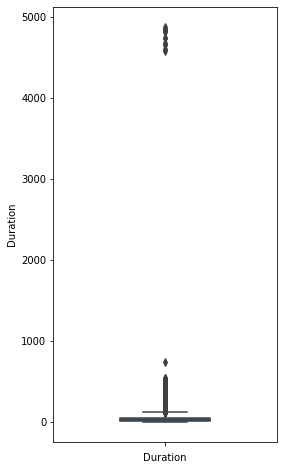

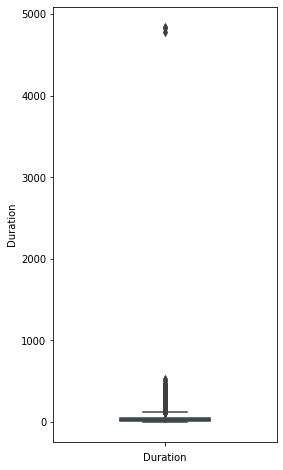

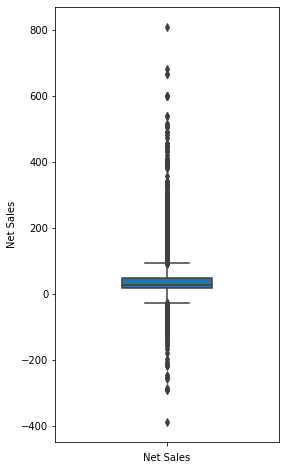

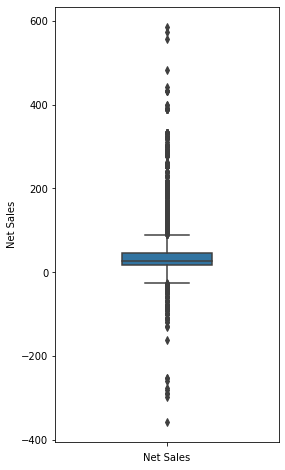

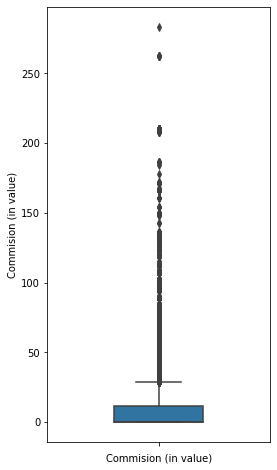

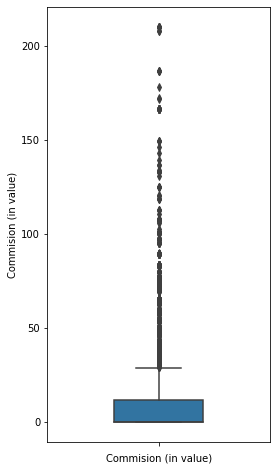

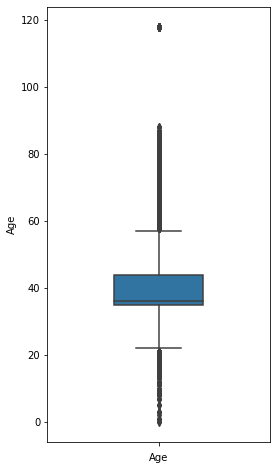

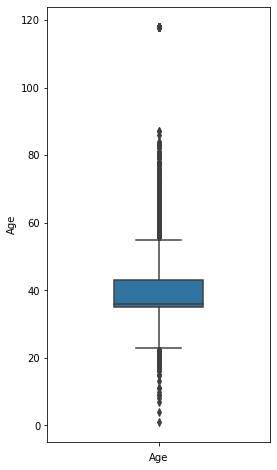

In [15]:
# pycharm slow

for col in cols_num:
    for df_ in (train, test):
        plt.figure(figsize=(4, 8),)
        fig = sns.boxplot(y=df_[col], width=0.4,)
        fig.set_xlabel(col)
        plt.show()
    

#### Checking and modifying the numerical columns in the dataframes
* Duration contains outliers (>4000)
    * Need to investigate further
* Net Sales can be negative/positive
    * Looks OK
* Commision looks OK
* Age contains outliers (>100)
    * Need to investigate

In [16]:
print(cols_num)

['Duration', 'Net Sales', 'Commision (in value)', 'Age']


In [17]:
for df_ in (train, test):
    print(df_[df_['Duration']<0][cols_num])

       Duration  Net Sales  Commision (in value)  Age
4063         -1       18.0                   6.3  118
38935        -1       18.0                   6.3  118
48367        -2       22.0                   7.7  118
      Duration  Net Sales  Commision (in value)  Age
802         -1       22.0                   7.7  118
4432        -1       18.0                   6.3  118


In [18]:
for df_ in (train, test):
    print(df_[df_['Duration']>4000][cols_num])
    

       Duration  Net Sales  Commision (in value)  Age
12083      4609       0.32                  0.09   48
15326      4580       0.32                  0.09   48
16797      4685       0.32                  0.09   48
17702      4736       0.32                  0.09   48
23844      4844       0.32                  0.09   48
27270      4857       0.32                  0.09   48
28143      4815       0.32                  0.09   48
30465      4652       0.32                  0.09   48
31070      4829       0.32                  0.09   48
42137      4738       0.32                  0.09   48
43742      4881       0.13                  0.04   48
       Duration  Net Sales  Commision (in value)  Age
1118       4784       0.32                  0.09   48
4157       4831       0.32                  0.09   48
12170      4847       0.32                  0.09   48


In [19]:
for df_ in (train, test):
    print(df_[df_['Commision (in value)']<0][cols_num])


Empty DataFrame
Columns: [Duration, Net Sales, Commision (in value), Age]
Index: []
Empty DataFrame
Columns: [Duration, Net Sales, Commision (in value), Age]
Index: []


In [20]:
for df_ in (train, test):
    print(df_[df_['Age']<0][cols_num])
    
train.drop(train[train['Age']<=0].index, axis=0, inplace=True,)
    

Empty DataFrame
Columns: [Duration, Net Sales, Commision (in value), Age]
Index: []
Empty DataFrame
Columns: [Duration, Net Sales, Commision (in value), Age]
Index: []


In [21]:
for col in cols_num:
    print(train[col].describe().T, '\n')

count    50551.000000
mean        49.424205
std        101.436266
min         -2.000000
25%          9.000000
50%         22.000000
75%         53.000000
max       4881.000000
Name: Duration, dtype: float64 

count    50551.000000
mean        40.802591
std         48.899613
min       -389.000000
25%         18.000000
50%         26.500000
75%         48.000000
max        810.000000
Name: Net Sales, dtype: float64 

count    50551.000000
mean         9.838064
std         19.910433
min          0.000000
25%          0.000000
50%          0.000000
75%         11.550000
max        283.500000
Name: Commision (in value), dtype: float64 

count    50551.000000
mean        40.012819
std         14.074594
min          1.000000
25%         35.000000
50%         36.000000
75%         44.000000
max        118.000000
Name: Age, dtype: float64 



* Duration
    * Contained negative values in both train and test
        * Seems like a code for why the flight was cancelled, not modified
    * Values >4000
        * Similar values found in test set, not modified
* Age
    * 2 records containing negative values
        * Removed
    * Entries with age 118
        * Found similar in test set, not modified

* Duration shouldn't be negative but the test set has 2 negative values as well
* Not modifying the negative values

#### Looking for interesting trends before training the model

In [22]:
# Checking for commision vs claims given
table_1 = pd.crosstab(train['Agency'], train['Claim'], margins=True,)
table_1.drop(index=['All'], inplace=True,)
total = table_1['All'].copy()
table = (table_1.div(table_1['All'], axis=0,)*100)
table_1['Total'] = total
table_1['Mean Commission'] = train.groupby('Agency')['Commision (in value)'].mean()
table_1.sort_values(by='Mean Commission', inplace=True, ascending=False,)
print(table)

Claim            0         1    All
Agency                             
ADM     100.000000  0.000000  100.0
ART      99.632353  0.367647  100.0
C2B      93.379581  6.620419  100.0
CBH      98.765432  1.234568  100.0
CCR      98.101266  1.898734  100.0
CSR      98.529412  1.470588  100.0
CWT      99.005848  0.994152  100.0
EPX      99.457182  0.542818  100.0
JWT      99.504950  0.495050  100.0
JZI      99.505831  0.494169  100.0
KML      97.791798  2.208202  100.0
LWC      94.708029  5.291971  100.0
RAB      99.824869  0.175131  100.0
SSI      99.404052  0.595948  100.0
TST      99.522673  0.477327  100.0
TTW      94.805195  5.194805  100.0


In [23]:
# Correlation between mean commission and claims given
table_1[[0, 1, 'Mean Commission']].corr().drop([0, 1,], axis=1,)
# Insignificant Correlation

Claim,Mean Commission
Claim,
0,-0.201621
1,0.028848
Mean Commission,1.000000


In [24]:
def get_agency_name(product_name):
    return train[train['Product Name']==product_name]['Agency'].iloc[0]

table_2 = pd.crosstab(train['Product Name'], train['Claim'], margins=True,)
table_2 = table_2.div(table_2['All'], axis=0,)*100
table_2['Mean Commission'] = train.groupby('Product Name')['Commision (in value)'].mean()
table_2['Total Commission'] = train.groupby('Product Name')['Commision (in value)'].sum()
table_2['Total Customers'] = train.groupby('Product Name')['Agency'].count()
table_2['Mean Commission/Claims Given'] = table_2['Mean Commission']/table_2[1]
table_2.drop(index=['All'],inplace=True)
table_2.sort_values(by='Mean Commission', ascending=False, inplace=True,)
table_2.reset_index(inplace=True,)
table_2['Agency'] = table_2['Product Name'].apply(get_agency_name)
table_2 = table_2[['Agency', 'Product Name', 0, 1, 'Mean Commission', 
                   'Total Commission', 'Total Customers', 
                   'Mean Commission/Claims Given']]
print(table_2)


Claim Agency                          Product Name           0          1  \
0        LWC        Annual Travel Protect Platinum   97.777778   2.222222   
1        LWC            Annual Travel Protect Gold   87.654321  12.345679   
2        LWC          Annual Travel Protect Silver   94.520548   5.479452   
3        C2B                      Annual Gold Plan   88.513514  11.486486   
4        C2B                    Annual Silver Plan   88.927336  11.072664   
5        CWT       Rental Vehicle Excess Insurance   99.005848   0.994152   
6        LWC   Single Trip Travel Protect Platinum   91.228070   8.771930   
7        KML                          Premier Plan   98.101266   1.898734   
8        LWC       Single Trip Travel Protect Gold   95.597484   4.402516   
9        LWC     Single Trip Travel Protect Silver   98.496241   1.503759   
10       C2B                             Gold Plan   95.205479   4.794521   
11       JZI                            Value Plan   99.308437   0.691563   

In [25]:
# Need to find commission per plan subsricption summation
grouped_agency = table_2.groupby('Agency')
table_3 = grouped_agency['Total Commission'].sum()/grouped_agency['Total Customers'].sum()
table_3.sort_values(inplace=True, ascending=False)
table_3 = pd.DataFrame(table_3)
table_3.columns = ['Mean Commission']

commissions_hmean = {}
for commissions in list(grouped_agency['Mean Commission']):
    for commission in commissions[1:]:
        commissions_hmean[commissions[0]] = stats.hmean(list(commission))

table_3.reset_index(inplace=True)
table_3 = pd.merge(table_3, pd.DataFrame({'Agency':list(commissions_hmean.keys()), 'Hmean Commission':list(commissions_hmean.values())}))

print(table_3)

   Agency  Mean Commission  Hmean Commission
0     LWC        76.591314         46.110682
1     CWT        32.254026         32.254026
2     KML        30.664430         30.664430
3     C2B        20.572378         18.601123
4     JZI        12.675647         12.683675
5     TST        10.500000         10.500000
6     CSR         9.946177          9.946177
7     ART         8.464221          8.464221
8     SSI         1.804207          1.804207
9     TTW         0.000000          0.000000
10    EPX         0.000000          0.000000


In [26]:
X, y = train.drop('Claim', axis=1,), train['Claim'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=4,)




In [27]:
for df_ in (train, test):
    print(df_[df_['Duration']==0]['Claim'].value_counts())
    break
    

0    54
Name: Claim, dtype: int64


No claims have been given for flights that were cancelled or unattended

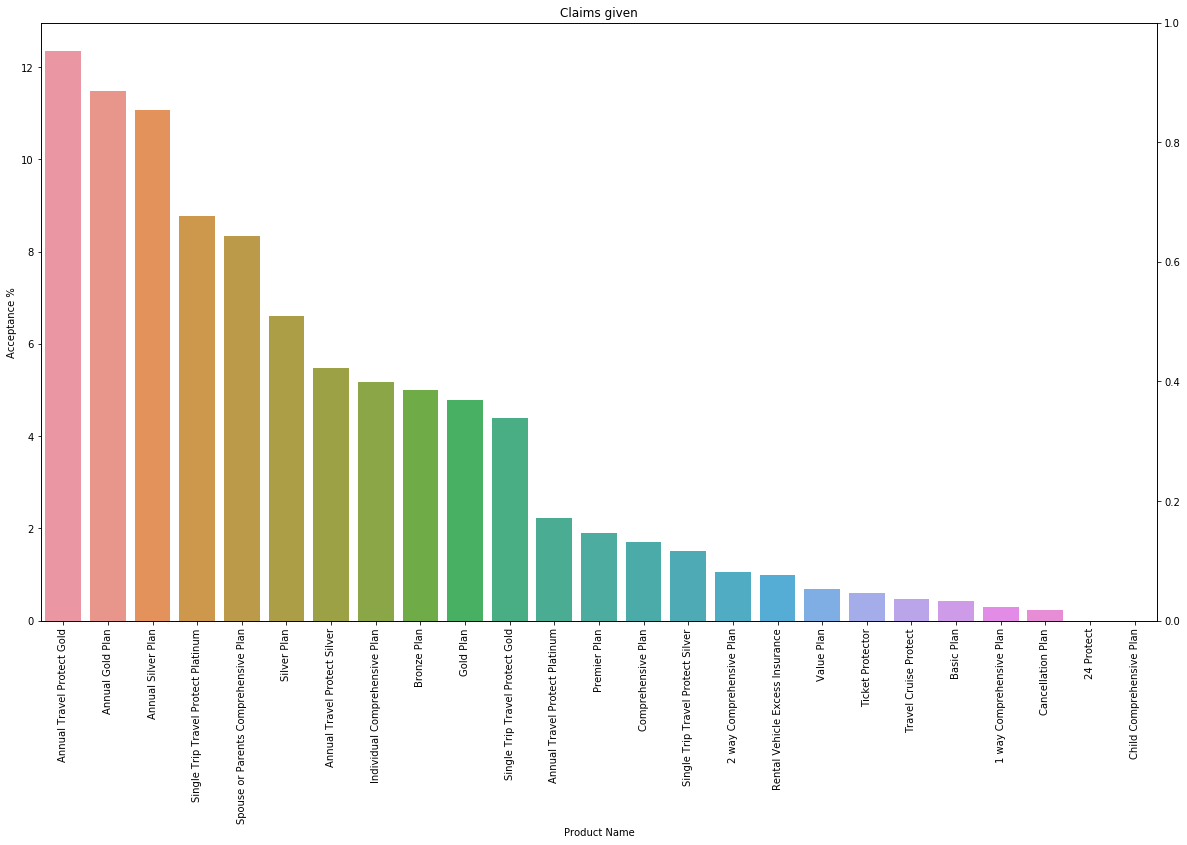

In [28]:
# pycharm slow

fig,ax1 = plt.subplots(figsize=(20,11),)
sns.barplot(x=table_2['Product Name'], y=table_2[1], ax=ax1,
            order=table_2.iloc[ table_2[1].sort_values(ascending=False,).index, 1 ],
            )
plt.xticks(rotation=90,)
ax1.set(ylabel='Acceptance %',)
ax2 = ax1.twinx()
plt.title('Claims given')
plt.show()

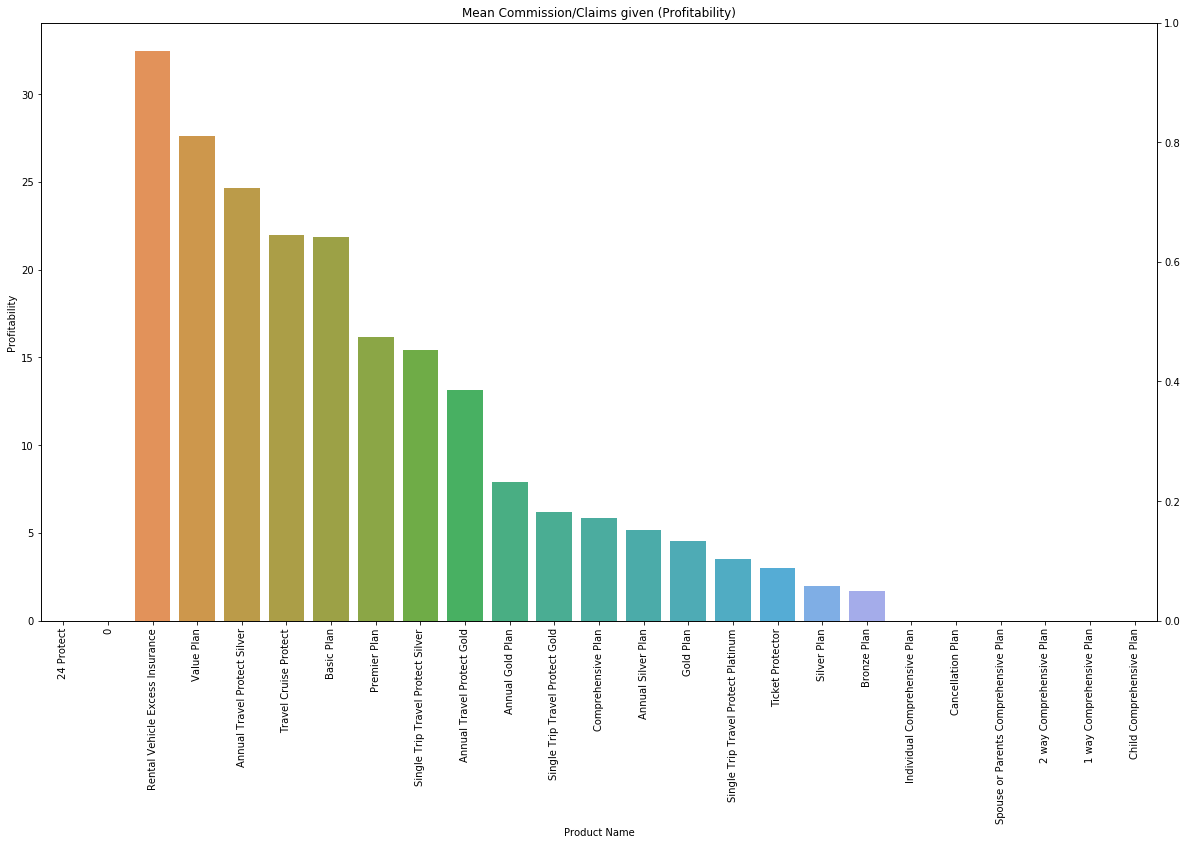

In [29]:
# pycharm slow
# 
fig,ax1 = plt.subplots(figsize=(20,11),)

graph_order = table_2.iloc[ table_2['Mean Commission/Claims Given'].sort_values(ascending=False,).index, 1 ].copy()
graph_order.fillna(0, inplace=True,)
graph_order.iloc[17] = 0

order_list = table_2.iloc[ table_2['Mean Commission/Claims Given'].sort_values(ascending=False,).index, 1 ]
order_list.fillna(0, inplace=True,)
order_list[0]=0

sns.barplot(x=table_2['Product Name'], 
            y=table_2['Mean Commission/Claims Given'], ax=ax1,
            order=order_list,
            )
plt.xticks(rotation=90,)
ax1.set(ylabel='Profitability',)
ax2 = ax1.twinx()
plt.title('Mean Commission/Claims given (Profitability)')
plt.show()

* It seems that '' is the most profitable product

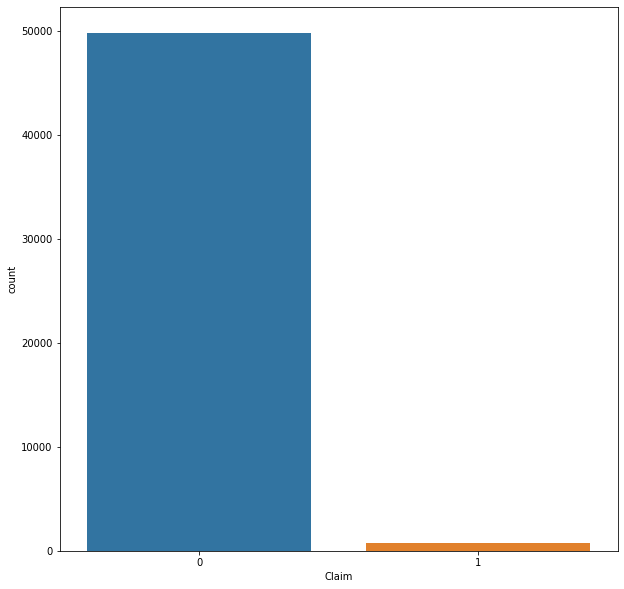

In [30]:
# pycharm slow

plt.figure(figsize=(10, 10))
sns.countplot(train['Claim'])
plt.show()

* It is observed that the target variable is highly imbalanced
    * This will be dealt with before training

* Looking to see which features are important for prediction
* Using Chi Square Test

* Need to perform label encoding before that

In [31]:
from scipy.stats import chi2_contingency

class ChiSquare:
    def __init__(self, df):
        self.df = df
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT for Prediction".format(colX)
        else:
            result="{0} is NOT an important predictor. (Discard {0} from model)".format(colX)

        print(result)
        
    def TestIndependence(self,colX,colY, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX,alpha)

In [32]:
train_copy = train.copy()

for col in cols_cat:
    le = LabelEncoder()
    train_copy[col] = le.fit_transform(train_copy[col],)

X = train_copy.drop('Claim', axis=1,)
chi2_test = ChiSquare(train_copy,)

for col in X.columns:
    chi2_test.TestIndependence(col, 'Claim',)

ID is NOT an important predictor. (Discard ID from model)
Agency is IMPORTANT for Prediction
Agency Type is IMPORTANT for Prediction
Distribution Channel is NOT an important predictor. (Discard Distribution Channel from model)
Product Name is IMPORTANT for Prediction
Duration is IMPORTANT for Prediction
Destination is IMPORTANT for Prediction
Net Sales is IMPORTANT for Prediction
Commision (in value) is IMPORTANT for Prediction
Age is IMPORTANT for Prediction


* Dropping Distribution Channel and ID

In [33]:
train_copy.drop(['ID', 'Distribution Channel'], axis=1, inplace=True,)
print(train_copy.head(1).T)

                          0
Agency                 6.00
Agency Type            1.00
Product Name          16.00
Claim                  0.00
Duration               7.00
Destination           56.00
Net Sales              0.00
Commision (in value)  17.82
Age                   31.00


In [34]:
X, y = train_copy.drop('Claim', axis=1,), train_copy['Claim']

In [35]:
model = ExtraTreesClassifier(random_state=4,)
model.fit(X, y,)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=4, verbose=0,
                     warm_start=False)

In [36]:
temp_dict = {}
for i, j in zip(range(len(model.feature_importances_)), model.feature_importances_):
    temp_dict[X.columns[i]] = j

feature_importances = pd.Series(data=list(temp_dict.values()), index=temp_dict.keys())
print(feature_importances)

Agency                  0.015255
Agency Type             0.007779
Product Name            0.015476
Duration                0.383790
Destination             0.051880
Net Sales               0.149759
Commision (in value)    0.084083
Age                     0.291977
dtype: float64


In [37]:
# feature_importances.nlargest(n=len(feature_importances),).plot(kind='barh')
# plt.show()

* Using inbuilt class feature_importances of tree based classifiers, the
feature importance has been obtained

* Finding out the correlation values amongst all columns.

In [38]:
corr_matrix = X.corr()
# corr_matrix.style.background_gradient(cmap='coolwarm')


* Correlation matrix shows higher correlation of duration with net sales and 
commission 
* Proceeding to modeling phase

* The problem at hand is a imbalanced class classification problem
    * 8 features and 50,551 records
    * There are high number of data points available so SVMs might also be useful
* Models to use
    * Logistic Regression
    * Decision Tree Classifier
    * Random Forest
    * K-NN
    * SVM
    * XGBoost

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=4,
                                                    stratify=y,)

$Logistic$ $Regression$

In [40]:
model = LogisticRegression(random_state=4,)
hyperparameters = {
    'penalty': ['l1', 'l2', 'elasticnet', 'None'],
    'C': [0.05, 0.25, 0.7, 1, 2,],
    'class_weight': ['balanced', {0:0.2, 1:1,}],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter':[100, 500,],
    'n_jobs': [-1],
    'l1_ratio': [0.25, 0.5, 0.75,],
}

clf_gscv = GridSearchCV(model, hyperparameters, cv=10, verbose=0, 
                        scoring='roc_auc', n_jobs=-1, return_train_score=True,)
start_time = time.time()

best_model = clf_gscv.fit(X_train, y_train,)

time_taken_s = np.around(time.time()-start_time, decimals=2,)
time_taken_m = time_taken_s/60  
print('Total Time taken = {0} seconds \nIn minutes: {1}'.format(time_taken_s,
                                                                time_taken_m,))
# 34 minutes

Total Time taken = 2516.17 seconds 
In minutes: 41.936166666666665


In [60]:
results = clf_gscv.cv_results_.copy()

In [118]:
for key in results.keys():
    print(len(results[key]), type(results[key]), key,  )

1200 <class 'numpy.ndarray'> mean_fit_time
1200 <class 'numpy.ndarray'> std_fit_time
1200 <class 'numpy.ndarray'> mean_score_time
1200 <class 'numpy.ndarray'> std_score_time
1200 <class 'numpy.ma.core.MaskedArray'> param_C
1200 <class 'numpy.ma.core.MaskedArray'> param_class_weight
1200 <class 'numpy.ma.core.MaskedArray'> param_l1_ratio
1200 <class 'numpy.ma.core.MaskedArray'> param_max_iter
1200 <class 'numpy.ma.core.MaskedArray'> param_n_jobs
1200 <class 'numpy.ma.core.MaskedArray'> param_penalty
1200 <class 'numpy.ma.core.MaskedArray'> param_solver
1200 <class 'list'> params
1200 <class 'numpy.ndarray'> split0_test_score
1200 <class 'numpy.ndarray'> split1_test_score
1200 <class 'numpy.ndarray'> split2_test_score
1200 <class 'numpy.ndarray'> split3_test_score
1200 <class 'numpy.ndarray'> split4_test_score
1200 <class 'numpy.ndarray'> split5_test_score
1200 <class 'numpy.ndarray'> split6_test_score
1200 <class 'numpy.ndarray'> split7_test_score
1200 <class 'numpy.ndarray'> split8_tes

In [121]:
saved_model_gsccv_log_reg = pickle.dumps(clf_gscv)

In [50]:
model_from_pickle = pickle.loads(saved_model_gsccv_log_reg) 
  
# Use the loaded pickled model to make predictions 
model_from_pickle.predict(X_test) 

array([1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,

In [51]:
type(saved_model_gsccv_log_reg)

bytes

In [52]:
a = clf_gscv

In [122]:
with open('trained_model.pickle', 'wb') as handle:
    pickle.dump(clf_gscv, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [123]:
with open('trained_model.pickle', 'rb') as handle:
    b = pickle.load(handle)


In [126]:
print(a)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=4, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.05, 0.25, 0.7, 1, 2],
                         'class_weight': ['balanced', {0: 0.2, 1: 1}],
                         'l1_ratio': [0.25, 0.5, 0.75], 'max_iter': [100, 500],
                         'n_jobs': [-1],
                         'penalty': ['l1', 'l2', 'elasticnet', 'None'],
                         'solver': ['

In [125]:
print(b)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=4, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.05, 0.25, 0.7, 1, 2],
                         'class_weight': ['balanced', {0: 0.2, 1: 1}],
                         'l1_ratio': [0.25, 0.5, 0.75], 'max_iter': [100, 500],
                         'n_jobs': [-1],
                         'penalty': ['l1', 'l2', 'elasticnet', 'None'],
                         'solver': ['

In [136]:
if False in (b.predict(X_test) == a.predict(X_test)):
    print(False)
else:
    print(True)
# All predicted values are same, meaming that the model was correctly saved

True


In [108]:
# Creating a dictionary out of the GridSearchCV results
results_dict = {}
for key in results.keys():
    if key == "params":
        results_dict[key] = [ str(i) for i in results[key] ]
    else:
        results_dict[key] = list(results[key])
results_df = pd.DataFrame(data=results_dict,)

In [ ]:
results_df.isnull().sum()
# Some results were null due to incorrect model parameters or failure to converge in given number of iterations

In [ ]:
# printing the remaining values
results_df.dropna(axis=0, inplace=True)
print(results_df.head(1).T)

In [ ]:
len(results_df['params'].value_counts())
# Length of .value_counts() for parameters is same as number of entries, meaning all parameters were different.
# This isn't of much use and it would be better if all the parameters of the given dictionary were columns
# to further drill down and understand which parameters worked best.

In [ ]:
print(results_df[['mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score'))

In [ ]:
print(results_df.sort_values(by='mean_test_score', ascending=False).iloc[0,:])

In [ ]:
print(results_df[ (results_df.index==248) | (results_df.index==288) | (results_df.index==328) ].T)

In [ ]:
results_df[ results_df['params']==str(clf_gscv.best_params_)]

In [ ]:
eval(list(results_df[ results_df['params']==str(clf_gscv.best_params_)].loc[:,'params'])[0])

In [ ]:
# which is the same as
clf_gscv.best_params_

In [ ]:
best_model_lr = clf_gscv.best_estimator_
y_pred = best_model_lr.predict(X_test,)

In [ ]:
get_scores(best_model_lr, X_test, y_test,)

In [109]:
get_scores(best_model_lr, X_test, y_test,)

mean_fit_time           0
std_fit_time            0
mean_score_time         0
std_score_time          0
param_C                 0
param_class_weight      0
param_l1_ratio          0
param_max_iter          0
param_n_jobs            0
param_penalty           0
param_solver            0
params                  0
split0_test_score     720
split1_test_score     720
split2_test_score     720
split3_test_score     720
split4_test_score     720
split5_test_score     720
split6_test_score     720
split7_test_score     720
split8_test_score     720
split9_test_score     720
mean_test_score       720
std_test_score        720
rank_test_score         0
split0_train_score    720
split1_train_score    720
split2_train_score    720
split3_train_score    720
split4_train_score    720
split5_train_score    720
split6_train_score    720
split7_train_score    720
split8_train_score    720
split9_train_score    720
mean_train_score      720
std_train_score       720
dtype: int64

In [110]:
# printing the remaining values
results_df.dropna(axis=0, inplace=True)
print(results_df.head(1).T)

                                                                    2
mean_fit_time                                                0.414891
std_fit_time                                                0.0373262
mean_score_time                                            0.00698168
std_score_time                                             0.00381072
param_C                                                          0.05
param_class_weight                                           balanced
param_l1_ratio                                                   0.25
param_max_iter                                                    100
param_n_jobs                                                       -1
param_penalty                                                      l1
param_solver                                                liblinear
params              {'C': 0.05, 'class_weight': 'balanced', 'l1_ra...
split0_test_score                                            0.735733
split1_test_score   

In [137]:
len(results_df['params'].value_counts())
# Length of .value_counts() for parameters is same as number of entries, meaning all parameters were different.
# This isn't of much use and it would be better if all the parameters of the given dictionary were columns
# to further drill down and understand which parameters worked best.

480

In [142]:
print(results_df[['mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score'))

     mean_train_score  mean_test_score  rank_test_score
248          0.783039         0.779633                1
288          0.783039         0.779633                1
328          0.783039         0.779633                1
728          0.783039         0.779633                4
568          0.783039         0.779633                4
..                ...              ...              ...
174          0.650969         0.650389              476
214          0.650932         0.650348              477
204          0.650894         0.650303              478
124          0.650894         0.650303              478
164          0.650894         0.650303              478

[480 rows x 3 columns]


In [155]:
print(results_df.sort_values(by='mean_test_score', ascending=False).iloc[0,:])

mean_fit_time                                                   1.01632
std_fit_time                                                  0.0624674
mean_score_time                                              0.00279303
std_score_time                                              0.000398553
param_C                                                            0.25
param_class_weight                                             balanced
param_l1_ratio                                                     0.25
param_max_iter                                                      100
param_n_jobs                                                         -1
param_penalty                                                        l2
param_solver                                                        sag
params                {'C': 0.25, 'class_weight': 'balanced', 'l1_ra...
split0_test_score                                              0.759624
split1_test_score                                              0

In [148]:
print(results_df[ (results_df.index==248) | (results_df.index==288) | (results_df.index==328) ].T)

                                                                  248  \
mean_fit_time                                                 1.01632   
std_fit_time                                                0.0624674   
mean_score_time                                            0.00279303   
std_score_time                                            0.000398553   
param_C                                                          0.25   
param_class_weight                                           balanced   
param_l1_ratio                                                   0.25   
param_max_iter                                                    100   
param_n_jobs                                                       -1   
param_penalty                                                      l2   
param_solver                                                      sag   
params              {'C': 0.25, 'class_weight': 'balanced', 'l1_ra...   
split0_test_score                                  

In [153]:
results_df[ results_df['params']==str(clf_gscv.best_params_)]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_l1_ratio,param_max_iter,param_n_jobs,param_penalty,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
248,1.016323,0.062467,0.002793,0.000399,0.25,balanced,0.25,100,-1,l2,...,0.784145,0.779678,0.777654,0.786458,0.779705,0.789301,0.77889,0.785915,0.783039,0.003659


In [179]:
eval(list(results_df[ results_df['params']==str(clf_gscv.best_params_)].loc[:,'params'])[0])

{'C': 0.25,
 'class_weight': 'balanced',
 'l1_ratio': 0.25,
 'max_iter': 100,
 'n_jobs': -1,
 'penalty': 'l2',
 'solver': 'sag'}

In [180]:
# which is the same as
clf_gscv.best_params_

{'C': 0.25,
 'class_weight': 'balanced',
 'l1_ratio': 0.25,
 'max_iter': 100,
 'n_jobs': -1,
 'penalty': 'l2',
 'solver': 'sag'}

In [182]:
best_model_lr = clf_gscv.best_estimator_
y_pred = best_model_lr.predict(X_test,)

Accuracy: 0.790650138467625


Recall: 0.6801801801801802
Precision: 0.04639016897081413
F1 Score: 0.08685648547598505


ROC AUC: 0.7362357003684626


Confusion Matrix: 
[[11840  3104]
 [   71   151]]


Classification Report: 
              precision    recall  f1-score   support

           0       0.99      0.79      0.88     14944
           1       0.05      0.68      0.09       222

    accuracy                           0.79     15166
   macro avg       0.52      0.74      0.48     15166
weighted avg       0.98      0.79      0.87     15166



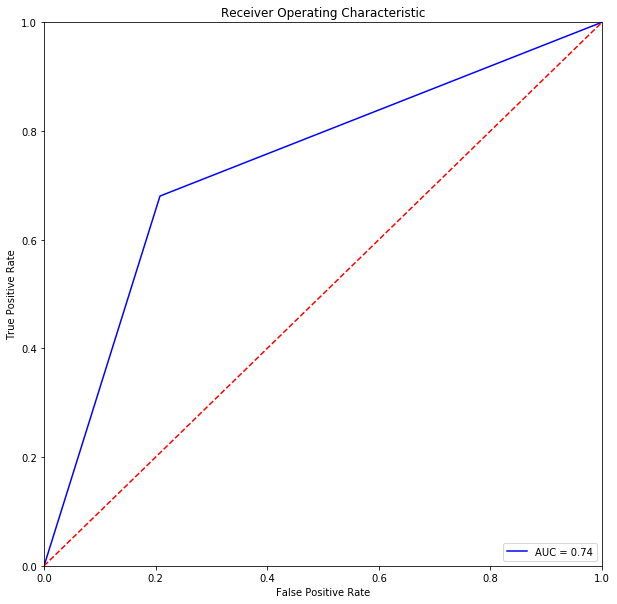

In [208]:
get_scores(best_model_lr, X_test, y_test,)